# MLP

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
torch.cuda.is_available()

True

## Import Data

In [2]:
df = pd.read_csv("../data/data.csv", index_col=0)
df['label'] = [int(s[-1]) for s in df['label']]
df.head()

,index,middle,ring,pinky,label
0,"[703.4, 703.5, 703.7, 703.9, 704.4, 705.0, 705...","[693.8, 693.8, 693.8, 693.8, 693.8, 693.9, 694...","[727.8, 727.8, 727.8, 727.8, 727.8, 727.9, 728...","[721.0, 721.0, 720.8, 720.1, 718.9, 717.2, 715...",0
1,"[702.0, 702.1, 702.4, 702.9, 703.6, 704.6, 705...","[693.0, 693.0, 693.0, 692.9, 692.9, 692.9, 692...","[727.4, 727.4, 727.3, 727.2, 727.2, 727.3, 727...","[722.2, 722.0, 721.4, 720.4, 718.9, 717.1, 715...",0
2,"[702.4, 702.5, 702.8, 703.5, 704.3, 705.4, 706...","[692.8, 692.8, 692.9, 692.8, 692.8, 692.7, 692...","[728.0, 728.0, 728.0, 727.9, 727.8, 727.7, 727...","[717.2, 716.9, 716.1, 714.8, 713.2, 711.3, 709...",0
3,"[704.8, 704.9, 705.3, 705.9, 706.8, 707.8, 708...","[693.4, 693.4, 693.3, 693.3, 693.1, 693.0, 692...","[727.4, 727.3, 727.2, 727.1, 727.0, 726.8, 726...","[714.8, 714.5, 713.5, 711.8, 709.8, 707.5, 705...",0
4,"[706.2, 706.3, 706.5, 706.9, 707.4, 708.0, 708...","[692.0, 692.0, 691.9, 691.9, 691.7, 691.6, 691...","[726.0, 726.0, 726.0, 726.0, 726.0, 726.0, 726...","[711.4, 711.3, 710.7, 709.7, 708.2, 706.3, 704...",0


In [3]:
## X
n_steps = len(json.loads(df.iloc[0,0]))
n_features = 4
X = np.empty((df.shape[0], n_steps*n_features), dtype=np.float64)
for i in range(X.shape[0]):    
    x = []
    for j in range(n_features):
        arr = list(json.loads(df.iloc[i,j]))
        x += arr
    X[i] = np.array(x)

## y
labels = df["label"].to_numpy()
le = LabelEncoder()
y = le.fit_transform(labels)
n_classes = len(np.unique(y))

## split
X_data, y_data = torch.Tensor(X), torch.LongTensor(y)
n = X_data.shape[0]
n_train = int(n * 0.8)
n_test =  n - n_train
data = torch.utils.data.TensorDataset(X_data, y_data)
train_data, val_data = torch.utils.data.random_split(data, [n_train, n_test])

## create dataloaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

## Training

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.linear_stack(x)

In [13]:
model = MLP(input_size=(n_steps*n_features), output_size=n_classes)
model = model.cuda()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
history = {
    "loss":[],
    "val_loss":[],
    "accuracy":[],
    "val_accuracy":[]
}

epochs = 300
for i in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    running_val_loss = 0.0
    running_val_corrects = 0

    ## Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # store loss & acc
        running_loss += loss.item() * inputs.shape[0]
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()

    ## Validation phase
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # store loss & acc
            running_val_loss += val_loss.item() * val_inputs.shape[0]
            _, val_preds = torch.max(val_outputs, 1)
            running_val_corrects += (val_preds == val_labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = running_val_corrects / len(val_loader.dataset)

    history["loss"].append(epoch_loss)
    history["accuracy"].append(epoch_acc)
    history["val_loss"].append(epoch_val_loss)
    history["val_accuracy"].append(epoch_val_acc)

    print(f"epoch: {i}, loss: {epoch_loss:.4f}, val_loss: {epoch_val_loss:.4f}, accuracy: {epoch_acc:.4f}, val_accuracy: {epoch_val_acc:.4f}")

MLP(
  (linear_stack): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=32, out_features=5, bias=True)
  )
)
epoch: 0, loss: 22.9884, val_loss: 17.7839, accuracy: 0.2115, val_accuracy: 0.2180
epoch: 1, loss: 15.5649, val_loss: 12.8718, accuracy: 0.2215, val_accuracy: 0.1760
epoch: 2, loss: 11.7109, val_loss: 9.7945, accuracy: 0.1840, val_accuracy: 0.1860
epoch: 3, loss: 8.9190, val_loss: 7.8112, accuracy: 0.2165, val_accuracy: 0.2100
epoch: 4, loss: 7.6308, val_loss: 6.7484, accuracy: 0.1850, val_accuracy: 0.2320
epoch: 5, loss: 6.8114, val_loss: 6.3518, accuracy: 0.1930, val_accuracy: 0.1940
epoch: 6, loss: 5.7236, val_loss: 5.3373, accuracy: 0.2140, va

Train accuracy:	0.9645
Val accuracy:	0.9740


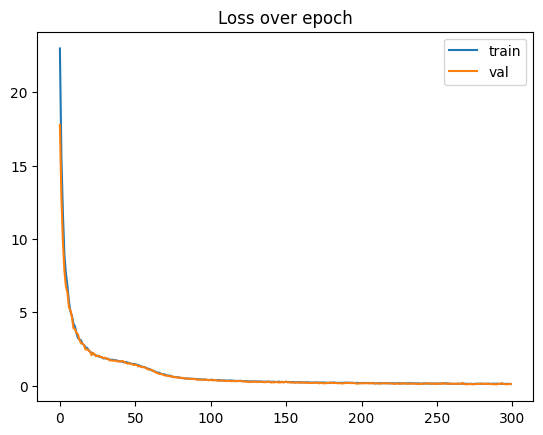

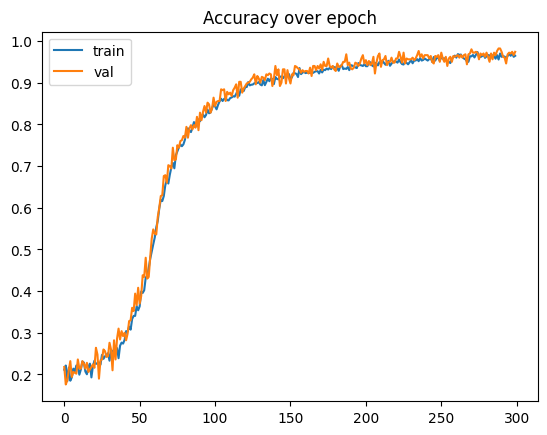

In [14]:
print(f"Train accuracy:\t{history['accuracy'][-1]:.4f}")
print(f"Val accuracy:\t{history['val_accuracy'][-1]:.4f}")

plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.title("Loss over epoch")
plt.legend()
plt.show()

plt.plot(history["accuracy"], label="train")
plt.plot(history["val_accuracy"], label="val")
plt.title("Accuracy over epoch")
plt.legend()
plt.show()

In [16]:
torch.save(model.state_dict(), "../models/mlp_torch")

In [19]:
model = MLP(input_size=n_steps*n_features, output_size=5).cuda()
model.load_state_dict(torch.load("../models/mlp_torch"))

<All keys matched successfully>